# Описание
Это ноутбук к первой контрольной точке.
В нем содержится код реализации алгоритма CEBC, описанного в статье. Работа с картой во многом наследована от наших лабораторных работ. Мы также использовали функцию prioritized_planning из лабораторной работы по многоагентному планированию, в качестве 'off-the-shelf CMAPF solver', описанного в оригинальной статье.  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/MyDrive/MIPT/Heuristics/MAPFOU")

In [3]:
from utils import Map, prioritized_planning, shortest_first, draw,simple_test, convert_string_to_cells, read_lists_from_file, manhattan_distance, check_paths
from collections import deque
import numpy as np

### MAPFOU


In [4]:
class SearchNode:
    def __init__(self, i,j, is_possible_obstacle=False, is_sense=False):
        self.i = i
        self.j = j
        self.left = None
        self.right = None
        self.is_sense = is_sense


    def __repr__(self):
        if self.is_sense:
            return "sense"
        else:
            return f"SearchNode({self.i, self.j})"
def create_branch(pairs):
    if not pairs:
        return None
    root = SearchNode(pairs[0][0], pairs[0][1])
    current = root
    for i, j in pairs[1:]:
        new_node = SearchNode(i, j)
        current.right = new_node
        current = current.right
    return root
def AssumeObs(task_map, c, u):
    new_map=task_map
    new_map._cells=np.zeros_like(task_map._cells)
    for i in u:
        new_map._cells[i[0]][i[1]] = 1
    for i in c:
        new_map._cells[i[0]][i[1]] = 1
    return new_map
def check_range(current_node, u):
    # Извлекаем координаты текущей вершины
    i, j = current_node.i, current_node.j
    # Создаем список возможных смежных координат
    adjacent_positions = [
        (i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)
    ]
    # Находим пересечение множества смежных позиций и множества u
    close_tuples = [pos for pos in adjacent_positions if pos in u]
    return close_tuples


## Псевдокод алгоритма
<img src='data/cebc_pseudocode.png' width=540, heigth=240>

In [5]:
def CEWC(graph, s, t, c, u):
    new_graph = AssumeObs(graph, c, u)
    #print(c)
    #print(graph._cells,'\n', new_graph._cells)
    plan = prioritized_planning(new_graph, s, t, 5000, manhattan_distance, shortest_first)[1]
    branches = [create_branch(path) for path in plan]
    queue = deque(branches)
    new_starts = []
    new_u = u.copy()
    previous_level_coords = [(k.i, k.j) for k in branches]
    while queue:
        next_level = deque()
        current_level_coords = []
        obstacle_found = False


        for node in queue:
            if node is not None:
                current_level_coords.append((node.i, node.j))

                # Проверка соседних узлов на наличие препятствий
                neighbors = [(node.i + 1, node.j), (node.i - 1, node.j), (node.i, node.j + 1), (node.i, node.j - 1)]
                for ni, nj in neighbors:
                    if (ni, nj) in new_u:

                        obstacle_found = True
                        obstacle_coords = (ni, nj)
                        new_u.remove(obstacle_coords)
                        break

                if node.right:
                    next_level.append(node.right)

        if obstacle_found:
            new_starts = previous_level_coords
        previous_level_coords = current_level_coords
        queue = next_level
        if obstacle_found:
            #print(c)
            subtrees_set = CEWC(graph, new_starts, t, c, new_u)
            counter = 0
            for n in branches:
                if (n.i, n.j) == (subtrees_set[counter].i, subtrees_set[counter].j):
                    buf = n.right
                    sense = SearchNode(n.i, n.j, is_sense=True)
                    n.right = sense
                    sense.right = buf
                    sense.left = subtrees_set[counter].right
                else:
                    while n.right:
                        if (n.i, n.j) == (subtrees_set[counter].i, subtrees_set[counter].j):
                            buf = n.right
                            sense = SearchNode(n.i, n.j, is_sense=True)
                            n.right = sense
                            sense.right = buf
                            try:
                                sense.left = subtrees_set[counter].right
                            except:
                                sense.left = subtrees_set[counter]
                            break
                        else:
                            n = n.right
                counter += 1
            u.remove(obstacle_coords)
    return branches

In [6]:
from collections import deque

def CEWC(graph, s, t, c, u):
    new_graph = AssumeObs(graph, c, u)
    plan = prioritized_planning(new_graph, s, t, 5000, manhattan_distance, shortest_first)[1]
    branches = [create_branch(path) for path in plan]
    queue = deque((i, branch) for i, branch in enumerate(branches) if branch is not None)
    new_starts = []
    new_u = u.copy()
    previous_level_coords = {i: [(k.i, k.j)] for i, k in enumerate(branches) if k is not None}

    while queue:
        next_level = deque()
        current_level_coords = {i: [] for i in range(len(branches))}
        obstacle_found = False

        while queue:
            idx, node = queue.popleft()
            if node:
                current_level_coords[idx].append((node.i, node.j))

                # Проверка соседних узлов на наличие препятствий
                neighbors = [(node.i + 1, node.j), (node.i - 1, node.j), (node.i, node.j + 1), (node.i, node.j - 1)]
                for ni, nj in neighbors:
                    if (ni, nj) in new_u:
                        obstacle_found = True
                        obstacle_coords = (ni, nj)
                        new_u.remove(obstacle_coords)

                if node.right:
                    next_level.append((idx, node.right))

        if obstacle_found:
            new_starts = [coords[-1] for coords in previous_level_coords.values()]


        previous_level_coords = {idx: previous_level_coords[idx] + current_level_coords[idx] for idx in previous_level_coords}
        queue = deque(next_level)

        if obstacle_found:
            subtrees_set = CEWC(graph, new_starts, t, c, new_u)
            subtrees_set = [subtree for subtree in subtrees_set if subtree is not None]
            counter = 0
            for n in branches:
                if n is not None and counter < len(subtrees_set):
                    if (n.i, n.j) == (subtrees_set[counter].i, subtrees_set[counter].j):
                        buf = n.right
                        sense = SearchNode(n.i, n.j, is_sense=True)
                        n.right = sense
                        sense.right = buf
                        sense.left = subtrees_set[counter].right
                    else:
                        while n.right:
                            if (n.i, n.j) == (subtrees_set[counter].i, subtrees_set[counter].j):
                                buf = n.right
                                sense = SearchNode(n.i, n.j, is_sense=True)
                                n.right = sense
                                sense.right = buf
                                try:
                                    sense.left = subtrees_set[counter].right
                                except:
                                    sense.left = subtrees_set[counter]
                                break
                            else:
                                n = n.right
                    counter += 1
            u.remove(obstacle_coords)
    return branches



## Визуализация и тесты

Карту пока что задаём непосредственно в самой ячейке запуска, это позволяет упростить изучение различных сценариев.

In [7]:
def print_tree(node=None, prefix="", children_prefix=""):
    if node is None:
        print('no root passed')
    node_repr = "sense" if node.is_sense else str((node.i, node.j))
    print(prefix + node_repr)
    if node.right:
        print_tree(node.right, children_prefix + "├── ", children_prefix + "│   ")
    if node.left:
        print_tree(node.left, children_prefix + "└── ", children_prefix + "    ")

In [8]:
def extract_path(nodes, test_map:Map, posible_paths):
  next_nodes = []
  right_trav, left_trav = [], []
  right_cont, left_cont = [], []
  #print((nodes[0].right.i, nodes[0].right.j))
  if all([not bool(node.right) for node in nodes]):
    for i, node in enumerate(nodes):
      if posible_paths[i][-1] != (node.i, node.j):
        posible_paths[i].append((node.i, node.j))
    return posible_paths
  for i,node in enumerate(nodes):
    if (not node.is_sense) or (not node.right and posible_paths[i][-1] != (node.i, node.j)):
      posible_paths[i].append((node.i, node.j))
    if node.right:
     right_trav.append(test_map.traversable(node.right.i, node.right.j))
    if node.left:
     left_trav.append(test_map.traversable(node.left.i, node.left.j))
  if all(right_trav):
    extract_path([(node.right if node.right else node) for node in nodes ], test_map, posible_paths)
    return posible_paths
  if all(left_trav):
     extract_path([(node.left if node.left else node)  for node in nodes], test_map, posible_paths)
     return posible_paths


In [9]:
map_str ='''
. . . . .
. . P . .
. # P . .
. . . . .
. . P . .

'''

cells = convert_string_to_cells(map_str)
task_map = Map(cells)
all_starts = read_lists_from_file("data/mapf_st_starts.txt")
all_goals = read_lists_from_file("data/mapf_st_goals.txt")
u = set([tuple(pos) for pos in np.argwhere(task_map._cells == 2)])
c = set([tuple(pos) for pos in np.argwhere(task_map._cells == 1)])
starts = all_starts[0]
goals = all_goals[0]
print(c)
trees = CEWC(task_map, starts, goals, c, u)

# Вывод структуры каждого дерева
for i, tree in enumerate(trees):
    print(f"Tree for agent {i+1}:")
    print_tree(tree)
    print()

{(2, 1)}
Tree for agent 1:
(4, 4)
├── sense
│   ├── sense
│   │   ├── (4, 3)
│   │   │   ├── (3, 3)
│   │   │   │   ├── (3, 2)
│   │   │   │   │   ├── (3, 1)
│   │   │   │   │   │   ├── (3, 0)
│   │   │   │   │   │   │   ├── (2, 0)
│   │   │   │   │   │   │   │   ├── (1, 0)
│   │   │   │   │   │   │   │   │   ├── (1, 1)
│   │   └── sense
│   │       ├── (3, 4)
│   │       │   ├── (2, 4)
│   │       │   │   ├── (1, 4)
│   │       │   │   │   ├── (1, 3)
│   │       │   │   │   │   ├── (1, 2)
│   │       │   │   │   │   │   ├── (1, 1)
│   │       └── (3, 4)
│   │           ├── (2, 4)
│   │           │   ├── (2, 3)
│   │           │   │   ├── (1, 3)
│   │           │   │   │   ├── (1, 2)
│   │           │   │   │   │   ├── (1, 1)
│   └── (3, 4)
│       ├── (3, 3)
│       │   ├── (2, 3)
│       │   │   ├── (2, 2)
│       │   │   │   ├── (1, 2)
│       │   │   │   │   ├── (1, 1)

Tree for agent 2:
(1, 1)
├── sense
│   ├── sense
│   │   ├── (0, 1)
│   │   │   ├── (0, 2)
│   │   │   │   ├── (0

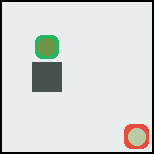

[[(4, 4), (4, 3), (3, 3), (3, 2), (3, 1), (3, 0), (2, 0), (1, 0), (1, 1)],
 [(1, 1), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]]

In [10]:
# Вывод структуры каждого дерева
paths = extract_path(trees, task_map, [[]for tree in trees])
draw(task_map,task_map,starts,goals,paths)
paths

# Тестирование

In [11]:
import pickle
with open("test_data.pkl", "rb") as f:
  test_data = pickle.load(f)

In [35]:
from tqdm import tqdm
full_pathes = []
for sample in tqdm(test_data):
  try:
        mask, test, starts, goals = sample
        right_paths = test_data[sample]
        mask_map = Map(convert_string_to_cells(mask))
        test_map = Map(convert_string_to_cells(test))
        u = set([tuple(pos) for pos in np.argwhere(mask_map._cells == 2)])
        c = set([tuple(pos) for pos in np.argwhere(mask_map._cells == 1)])
        trees = CEWC(mask_map, starts, goals, c, u)
        full_pathes.append([reverse_pre_order_traversal_with_path(tree) for tree in trees])
        paths = extract_path(trees, test_map, [[] for _ in trees])
        right_len = max(map(len,right_paths))
        max_len = max(map(len,paths))
        if not check_paths(starts, goals, paths) :
          print(f"Путь для {sample} некорректный")
          continue
  except:
      print(f"Критическая ошибка в {sample}")

100%|██████████| 89/89 [00:48<00:00,  1.83it/s]
